In [1]:
#Import packages (more than needed here)
import os
import glob
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
import math
from numpy import *
from pylab import *

import pyproj
import metpy.calc as mpcalc
import cartopy.crs as ccrs
from cartopy.geodesic import Geodesic
import cartopy.feature as cfeature
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
import wrf
from wrf import (to_np, interplevel, geo_bounds, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import shutil
# Download state and coastline data
states = NaturalEarthFeature(category="cultural", scale="50m",
                          facecolor="none", name="admin_1_states_provinces_shp")
from scipy.interpolate import RegularGridInterpolator
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker 
from matplotlib.patches import Rectangle

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime

/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#Function Below is for a storm following map projection. Credit: Dr. Sharanya Majumdar @The University of Miami
dataproj = ccrs.PlateCarree()

def create_map_background(tclon, tclat, ax=None):
    tclon5a = 5 * (int(tclon / 5) - 1)
    tclon5b = 5 * (int(tclon / 5))
    tclat5a = 5 * (int(tclat / 5) - 1)
    tclat5b = 5 * (int(tclat / 5))

    if ax is None:
        fig = plt.figure(figsize=(15, 15))
        ax = plt.subplot(111, projection=ccrs.PlateCarree())
    else:
        fig = None

    ax.set_extent([tclon - 5, tclon + 5, tclat - 5, tclat + 5], ccrs.PlateCarree())
    gl = ax.gridlines(color='gray', alpha=0.5, draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = gl.ylabel_style = {'fontsize': 16}
    gl.xlocator = mticker.FixedLocator([tclon5a - 10, tclon5a - 5, tclon5a, tclon5b, tclon5b + 5, tclon5b + 10])
    gl.ylocator = mticker.FixedLocator([tclat5a - 10, tclat5a - 5, tclat5a, tclat5b, tclat5b + 5, tclat5b + 10])
    gl.xformatter = LongitudeFormatter
    gl.yformatter = LatitudeFormatter
    ax.xaxis.set_major_formatter(gl.xformatter)
    ax.yaxis.set_major_formatter(gl.yformatter)

    return fig, ax

In [3]:
# set some constants for later use
deltap     = 5000.        # vertical isobaric spacing
resol      = 0.5          # degrees
pref       = 100000.      # Pa
cv         = 717.         # J kg-1 K-1
cp         = 1004.7       # J kg-1 K-1
omega      = 7.292e-5     # Rotation rate s-1       
rd         = 287.04       # J kg-1 K-1
fo         = 1.0e-4       # s-1; assume constant Coriolis parameter (Eliassen 1962)
po         = 100000.      # standard pressure (Pa)
r_earth    = 6.3781e6     # meters (Earth Radius)
grav       = 9.80665      # m/s-2
d2r        = (np.pi)/180. # degrees to radians
rv         = 461.50

def find_nearest(a, val):
    return np.abs(a - val).argmin()

In [4]:
#color scales for wind and IR-Brightness

from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def wind_color_scale():
    newcmp = LinearSegmentedColormap.from_list("", [
    (0/160, "#000000"), 
    (34/160, "#a6a6a6"),
    (34/160, "#4245a6"),
    (64/160, "#29a668"),
    (96/160, "#cccc33"),
    (113/160, "#cc3333"),
    (137/160, "#cc7acc"),
    (160/160, "#ffffff")])

    return newcmp

#New Color Scale for IR Brightness
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm

#Creating IR color Scale
def make_Ramp( ramp_colors ):
    from colour import Color
    from matplotlib.colors import LinearSegmentedColormap

    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    plt.figure( figsize = (15,3))
    plt.imshow( [list(np.arange(0, len( ramp_colors ) , 0.1)) ] , interpolation='nearest', origin='lower', cmap= color_ramp )
    plt.xticks([])
    plt.yticks([])
    return color_ramp

custom_ramp = make_Ramp( ["#00000a","#000014","#00001e","#000025","#00002a","#00002e","#000032","#000036","#00003a","#00003e",
                          "#000042","#000046","#00004a","#00004f","#000052","#010055","#010057","#020059","#02005c","#03005e",
                          "#040061","#040063","#050065","#060067","#070069","#08006b","#09006e","#0a0070","#0b0073","#0c0074",
                          "#0d0075","#0d0076","#0e0077","#100078","#120079","#13007b","#15007c","#17007d","#19007e","#1b0080",
                          "#1c0081","#1e0083","#200084","#220085","#240086","#260087","#280089","#2a0089","#2c008a","#2e008b",
                          "#30008c","#32008d","#34008e","#36008e","#38008f","#390090","#3b0091","#3c0092","#3e0093","#3f0093",
                          "#410094","#420095","#440095","#450096","#470096","#490096","#4a0096","#4c0097","#4e0097","#4f0097",
                          "#510097","#520098","#540098","#560098","#580099","#5a0099","#5c0099","#5d009a","#5f009a","#61009b",
                          "#63009b","#64009b","#66009b","#68009b","#6a009b","#6c009c","#6d009c","#6f009c","#70009c","#71009d",
                          "#73009d","#75009d","#77009d","#78009d","#7a009d","#7c009d","#7e009d","#7f009d","#81009d","#83009d",
                          "#84009d","#86009d","#87009d","#89009d","#8a009d","#8b009d","#8d009d","#8f009c","#91009c","#93009c",
                          "#95009c","#96009b","#98009b","#99009b","#9b009b","#9c009b","#9d009b","#9f009b","#a0009b","#a2009b",
                          "#a3009b","#a4009b","#a6009a","#a7009a","#a8009a","#a90099","#aa0099","#ab0099","#ad0099","#ae0198",
                          "#af0198","#b00198","#b00198","#b10197","#b20197","#b30196","#b40296","#b50295","#b60295","#b70395",
                          "#b80395","#b90495","#ba0495","#ba0494","#bb0593","#bc0593","#bd0593","#be0692","#bf0692","#bf0692",
                          "#c00791","#c00791","#c10890","#c10990","#c20a8f","#c30a8e","#c30b8e","#c40c8d","#c50c8c","#c60d8b",
                          "#c60e8a","#c70f89","#c81088","#c91187","#ca1286","#ca1385","#cb1385","#cb1484","#cc1582","#cd1681",
                          "#ce1780","#ce187e","#cf187c","#cf197b","#d01a79","#d11b78","#d11c76","#d21c75","#d21d74","#d31e72",
                          "#d32071","#d4216f","#d4226e","#d5236b","#d52469","#d62567","#d72665","#d82764","#d82862","#d92a60",
                          "#da2b5e","#da2c5c","#db2e5a","#db2f57","#dc2f54","#dd3051","#dd314e","#de324a","#de3347","#df3444",
                          "#df3541","#df363d","#e0373a","#e03837","#e03933","#e13a30","#e23b2d","#e23c2a","#e33d26","#e33e23",
                          "#e43f20","#e4411d","#e4421c","#e5431b","#e54419","#e54518","#e64616","#e74715","#e74814","#e74913",
                          "#e84a12","#e84c10","#e84c0f","#e94d0e","#e94d0d","#ea4e0c","#ea4f0c","#eb500b","#eb510a","#eb520a",
                          "#eb5309","#ec5409","#ec5608","#ec5708","#ec5808","#ed5907","#ed5a07","#ed5b06","#ee5c06","#ee5c05",
                          "#ee5d05","#ee5e05","#ef5f04","#ef6004","#ef6104","#ef6204","#f06303","#f06403","#f06503","#f16603",
                          "#f16603","#f16703","#f16803","#f16902","#f16a02","#f16b02","#f16b02","#f26c01","#f26d01","#f26e01",
                          "#f36f01","#f37001","#f37101","#f37201","#f47300","#f47400","#f47500","#f47600","#f47700","#f47800",
                          "#f47a00","#f57b00","#f57c00","#f57e00","#f57f00","#f68000","#f68100","#f68200","#f78300","#f78400",
                          "#f78500","#f78600","#f88700","#f88800","#f88800","#f88900","#f88a00","#f88b00","#f88c00","#f98d00",
                          "#f98d00","#f98e00","#f98f00","#f99000","#f99100","#f99200","#f99300","#fa9400","#fa9500","#fa9600",
                          "#fb9800","#fb9900","#fb9a00","#fb9c00","#fc9d00","#fc9f00","#fca000","#fca100","#fda200","#fda300",
                          "#fda400","#fda600","#fda700","#fda800","#fdaa00","#fdab00","#fdac00","#fdad00","#fdae00","#feaf00",
                          "#feb000","#feb100","#feb200","#feb300","#feb400","#feb500","#feb600","#feb800","#feb900","#feb900",
                          "#feba00","#febb00","#febc00","#febd00","#febe00","#fec000","#fec100","#fec200","#fec300","#fec400",
                          "#fec500","#fec600","#fec700","#fec800","#fec901","#feca01","#feca01","#fecb01","#fecc02","#fecd02",
                          "#fece03","#fecf04","#fecf04","#fed005","#fed106","#fed308","#fed409","#fed50a","#fed60a","#fed70b",
                          "#fed80c","#fed90d","#ffda0e","#ffda0e","#ffdb10","#ffdc12","#ffdc14","#ffdd16","#ffde19","#ffde1b",
                          "#ffdf1e","#ffe020","#ffe122","#ffe224","#ffe226","#ffe328","#ffe42b","#ffe42e","#ffe531","#ffe635",
                          "#ffe638","#ffe73c","#ffe83f","#ffe943","#ffea46","#ffeb49","#ffeb4d","#ffec50","#ffed54","#ffee57",
                          "#ffee5b","#ffee5f","#ffef63","#ffef67","#fff06a","#fff06e","#fff172","#fff177","#fff17b","#fff280",
                          "#fff285","#fff28a","#fff38e","#fff492","#fff496","#fff49a","#fff59e","#fff5a2","#fff5a6","#fff6aa",
                          "#fff6af","#fff7b3","#fff7b6","#fff8ba","#fff8bd","#fff8c1","#fff8c4","#fff9c7","#fff9ca","#fff9cd",
                          "#fffad1","#fffad4","#fffbd8","#fffcdb","#fffcdf","#fffde2","#fffde5","#fffde8","#fffeeb","#fffeee",
                          "#fffef1","#fffef4","#fffff6"]) 

top = custom_ramp
bottom = cm.get_cmap('Greys', 128)

newcolors = np.vstack((top(np.linspace(0,1,66)), 
                     bottom(np.linspace(0, 1, 33))))

newcmp = ListedColormap(newcolors, name = 'Cam_Cool_Color_Scale')

In [5]:
#Pressure levels we are considering for our aziumuthal averages
plevs  = [100000., 99000., 98000., 97000., 96000., 95000., 94000., 93000., 92000., 91000.,
           90000., 89000., 88000., 87000., 86000., 85000., 84000., 83000., 82000., 81000., 80000.,
           77500., 75000., 72500., 70000., 67500., 65000., 62500., 60000., 57500., 55000., 52500.,
           50000., 47500., 45000., 42500., 40000., 37500., 35000., 32500., 30000., 27500., 25000.,
           22500., 20000., 17500., 15000., 12500., 10000., 7500., 6000.]

#Vertical levels we are considering for azimuthal averages 
zlevs = [ 10., 20., 30., 40., 50., 60., 70., 80., 90., 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900., 1000.,
         1100., 1200., 1300., 1400., 1500., 1600., 1700., 1800., 1900., 2000., 2250.,
         2500., 2750., 3000., 3250., 3500., 3750., 4000., 4250., 4500., 4750., 5000.,
         5500., 6000., 6500., 7000., 7500., 8000., 8500., 9000., 9500., 10000., 10500.,
         11000., 11500., 12000., 12500., 13000., 13500., 14000., 14500., 15000., 15500.,
         16000., 16500., 17000., 17500., 18000., 18500.]

nlevs   = len(plevs) #level of interest is 850 hPa, which is the sixth level
n_zlevs = len(zlevs)

print("Number of Pressure levels in the vertical", nlevs)
print("Number of height levels in the vertical", n_zlevs)
yplabs = ['']*nlevs
yzlabs = ['']*n_zlevs

Number of Pressure levels in the vertical 51
Number of height levels in the vertical 68


In [6]:
#File path!
data_files = sorted(glob.glob('/Users/cjmasiel/Desktop/Anantha_Final/real_plane/wrfout_d02_files/wrfout_d02*'))

-4395.698


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


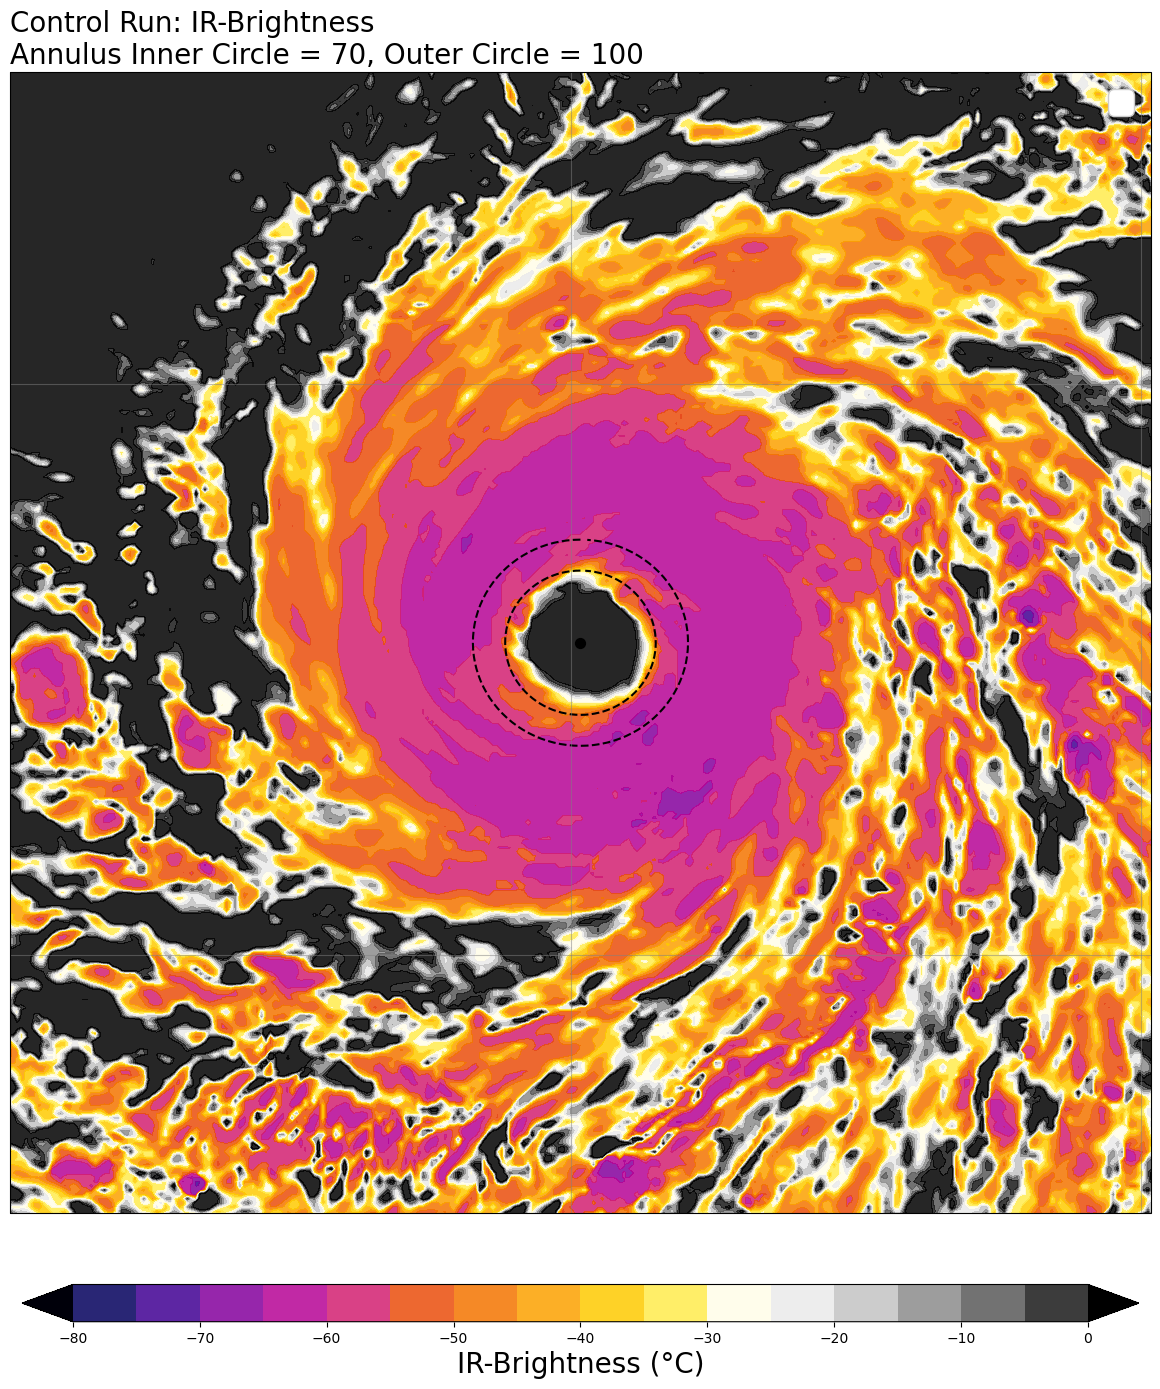

In [7]:
from math import sqrt

#for z in range(1, len(datafiles)):
for item in range(32,33):
    ncfile = Dataset(data_files[item])
    wrf_out_data = xr.open_dataset(data_files[item]) 
    
    #extract time from wrf files
    Time = wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, 
                             cache=None, meta=False, do_xtime=False)
    timestr=(str(Time))

    #for plotting
    titletime=(timestr[0:10]+' '+timestr[11:16])
    filetime= (timestr[0:10]+'_'+timestr[11:13])
    
    ##################################################################################################
    #Next, we will find the "center" of our TC by smoothing the pressure field!
    P_pertubation = wrf_out_data['P']
    surface_P_pertubation = P_pertubation[0,0,:,:]
    
    #Apply a Gaussian filter to smooth the pressure field
    smoothed_pressure = gaussian_filter(surface_P_pertubation, sigma=10)  # Adjust sigma as necessary

    #Now find the minimum pressure in the smoothed field
    minpressure_smoothed = np.min(smoothed_pressure)
    print(minpressure_smoothed)
    minp_smoothed = minpressure_smoothed

    #Get the index of the minimum pressure
    p_index_smoothed = np.argwhere(smoothed_pressure == minp_smoothed)
    s_n_smoothed = p_index_smoothed[0][0]
    w_e_smoothed = p_index_smoothed[0][1]

    #Update the storm center position
    ypos = s_n_smoothed
    xpos = w_e_smoothed

    tc_lon = wrf_out_data['XLONG'][0,s_n_smoothed,w_e_smoothed].values
    tc_lat = wrf_out_data['XLAT'][0,s_n_smoothed,w_e_smoothed].values
    ###################################################################################################
    #wrf inputs needed to calcualte IR Brightness 
    wrf_out_OLR =  wrf_out_data['OLR'][0,:,:]
    wrf_out_EMISS = wrf_out_data['EMISS'][0,:,:]
    lon = wrf_out_data['XLONG'][0,:,:].values
    lat = wrf_out_data['XLAT'][0,:,:].values
    
    #calculate IR brightness
    IR_Brigthness = -273.15 + (wrf_out_OLR.values + 310)/2
    
    #################################################################################################
    #plot IR-Brightness with circle inidcating azimuth!
    fig, ax = create_map_background(tc_lon,tc_lat)
    
    
    plot = plt.contourf(lon, lat, IR_Brigthness,
                        origin = 'lower', 
                        cmap = newcmp, 
                        levels = np.arange(-80, 5, 5), 
                        alpha = .85, 
                        extend ='both')

    cbar = plt.colorbar(plot, orientation = 'horizontal', pad = .05, shrink = .75, aspect = 30, extend = 'both')
    cbar.ax.set_xlabel('IR-Brightness (°C)', fontsize = 20)

    #for adding a circle to show azimuth 
    # Plot the position of the minimum pressure
    p_min_lon = tc_lon
    p_min_lat = tc_lat
    plt.scatter(p_min_lon, p_min_lat, color='black', s=50, zorder=5)
    
    #Draw a circle to represent the radius around the minimum pressure point
    radius_km1 = 70    #Specify this radius for what ever radius you want 
    radius_km2 = 100  
    
    #Define the geodetic circle
    geodetic = Geodesic()
    circle_points1 = geodetic.circle(lon=p_min_lon, lat=p_min_lat, radius=radius_km1 * 1000, n_samples=100)
    circle_points2 = geodetic.circle(lon=p_min_lon, lat=p_min_lat, radius=radius_km2 * 1000, n_samples=100)
    
    #Plot the circle on the map
    ax.plot(circle_points1[:, 0], circle_points1[:, 1], transform=ccrs.Geodetic(), color='black', linestyle='--')
    ax.plot(circle_points2[:, 0], circle_points2[:, 1], transform=ccrs.Geodetic(), color='black', linestyle='--')
    
    #Update the legend to include the new marker and circle
    plt.legend(loc='upper right', fontsize=24, framealpha=1)

    plt.title(f'Control Run: IR-Brightness\nAnnulus Inner Circle = {radius_km1}, Outer Circle = {radius_km2}', loc = 'left', fontsize = 20)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

    plt.show()
    plt.close()

-4395.698
[[ 4.36320234e-04  9.64790891e-04  1.50605919e-03 ... -1.49419599e-05
  -1.07900908e-05 -2.30404974e-05]
 [ 5.98735826e-04  1.17486420e-03  1.74258621e-03 ... -6.70215314e-05
  -6.45560619e-05 -5.16230112e-05]
 [ 4.73258493e-04  1.08628046e-03  1.69849207e-03 ... -1.33514430e-04
  -1.29325852e-04 -1.15144611e-04]
 ...
 [-5.04552566e-05 -5.19029891e-05  9.31659707e-06 ... -1.58469026e-04
  -1.61842595e-04 -1.58526915e-04]
 [-4.01921485e-05 -4.90135987e-05  1.48760583e-05 ... -1.61203357e-04
  -1.62758060e-04 -1.57153384e-04]
 [-3.93142270e-05 -6.75108601e-05 -2.80603226e-06 ... -1.64295798e-04
  -1.64078114e-04 -1.57696340e-04]]


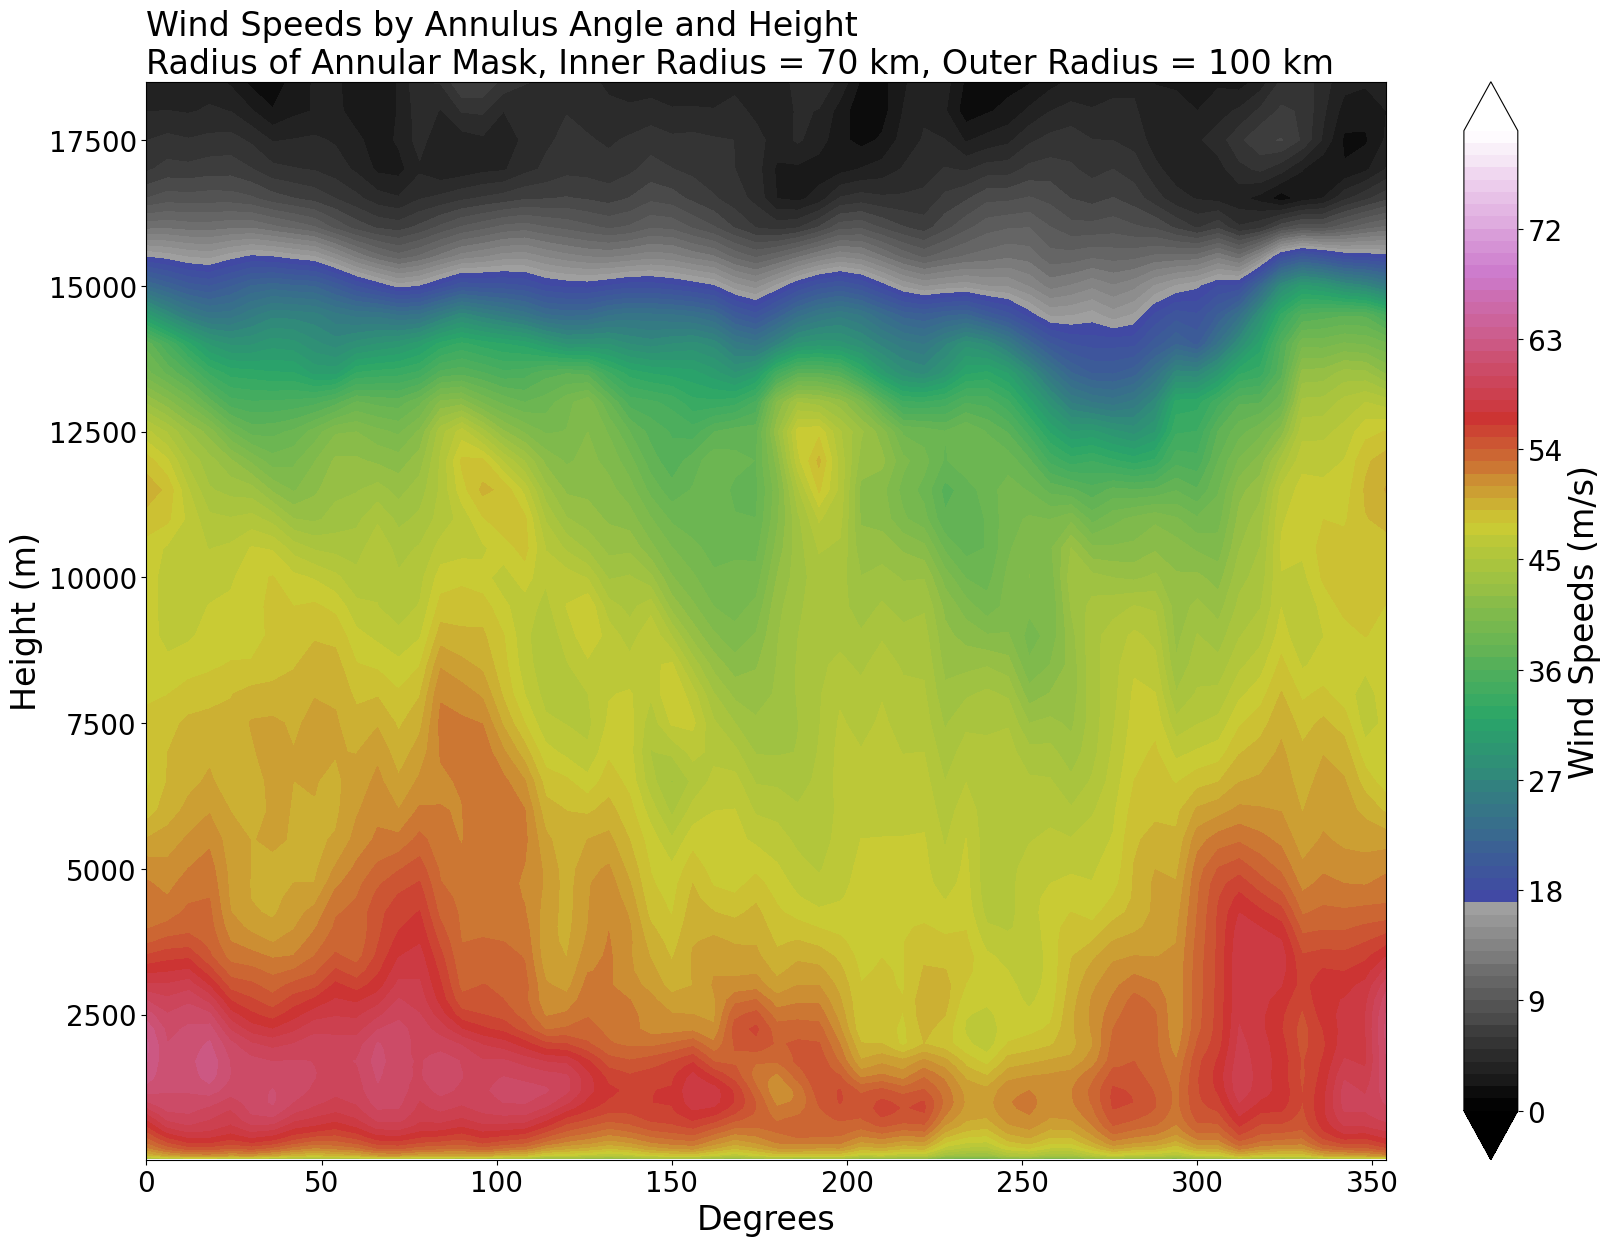

In [9]:
#annulus average visualiztion 

'''
first, define the bounds of our annulus:
    
    inner_radius_km = 70
    outer_radius_km = 100

This just specifies what azimuthal radius you want to analyze.

secondly:

    angle_bins = np.linspace(0, 360, 60, endpoint=False)

This line creates an array from 0 to 360 degrees. You Will need to manually change how many bins you want. 
60 refers to ~6°binning. This works well for 4 km grid spacing. 
For higher resolution data I have gone all the way up to 240 bins, which relates to about 1.5° binning.
This bin will depend on the radius chosen and the resolution of your data, so tinker as necessary!
'''


for item in range(32,33):
    ncfile = Dataset(data_files[item])
    wrf_out_data = xr.open_dataset(data_files[item]) 
    
    #extract time from wrf files
    Time = wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, 
                             cache=None, meta=False, do_xtime=False)
    timestr=(str(Time))

    #for plotting
    titletime=(timestr[0:10]+' '+timestr[11:16])
    filetime= (timestr[0:10]+'_'+timestr[11:13])
    
    ##################################################################################################
    #Next, we will find the "center" of our TC by smoothing the pressure field!
    P_pertubation = wrf_out_data['P']
    surface_P_pertubation = P_pertubation[0,0,:,:]
    
    #Apply a Gaussian filter to smooth the pressure field
    smoothed_pressure = gaussian_filter(surface_P_pertubation, sigma=10)  # Adjust sigma as necessary

    #Now find the minimum pressure in the smoothed field
    minpressure_smoothed = np.min(smoothed_pressure)
    print(minpressure_smoothed)
    minp_smoothed = minpressure_smoothed

    #Get the index of the minimum pressure
    p_index_smoothed = np.argwhere(smoothed_pressure == minp_smoothed)
    s_n_smoothed = p_index_smoothed[0][0]
    w_e_smoothed = p_index_smoothed[0][1]

    #Update the storm center position
    ypos = s_n_smoothed
    xpos = w_e_smoothed

    tc_lon = wrf_out_data['XLONG'][0,s_n_smoothed,w_e_smoothed].values
    tc_lat = wrf_out_data['XLAT'][0,s_n_smoothed,w_e_smoothed].values
    ###################################################################################################
    #wrf inputs needed to calcualte IR Brightness 
    wrf_out_OLR =  wrf_out_data['OLR'][0,:,:]
    wrf_out_EMISS = wrf_out_data['EMISS'][0,:,:]
    
    #calculate IR brightness
    IR_Brigthness = -273.15 + (wrf_out_OLR.values + 310)/2
    
    #################################################################################################
    #constants
    lats = getvar(ncfile, "XLAT")
    lons = getvar(ncfile, "XLONG") 
    land = getvar(ncfile, "LANDMASK")
    ptop = getvar(ncfile, "P_TOP")

    nx = lats.shape[0]
    ny = lats.shape[1]
    nz = P_pertubation.shape[1]

    #variables we will need for momentum calculations
    # Get variables 
    z_height = getvar(ncfile, "z")
    p        = getvar(ncfile, "pressure")
    ua       = getvar(ncfile, "ua")
    va       = getvar(ncfile, "va")
    theta    = getvar(ncfile, "theta")
    f        = wrf_out_data['F'][0,:,:]
    mix      = wrf_out_data['QVAPOR'][0,:,:,:]   #4d array for water vapor mixing ratio

    ugrd, vgrd, zgrd, pgrd, thgrd, mixgrd = [np.zeros([nx,ny,n_zlevs]) for _ in range(6)]  #Range is just the number of variables specified to the left

    for k in range (n_zlevs):
        clev = zlevs[k]
        yzlabs[k] = clev
        ##print('interpolating to: ',clev)

        # Do vertical interpolation to specified pressure surfaces (in hPa)
        uap   = interplevel(ua,    z_height, clev)
        vap   = interplevel(va,    z_height, clev)
        p_new = interplevel(p,     z_height, clev)
        the_z = interplevel(theta, z_height, clev)
        mix_z = interplevel(mix,   z_height, clev)

        #next, we append these interpolated lists to the grid
        ugrd[:,:,k] = uap[:,:]
        vgrd[:,:,k] = vap[:,:]
        pgrd[:,:,k] = p_new[:,:]
        thgrd[:,:,k] = the_z[:,:]
        mixgrd[:,:,k] = mix_z[:,:]

    #First, we have to create lists
    ydist, xdist, tcdist, rlonfac, theta_ang = [np.zeros([nx,ny]) for _ in range(5)]
    u_radial, v_azimuth, momentum, wind      = [np.zeros([nx,ny,n_zlevs]) for _ in range(4)]
    
    # compute distance from each grid point to storm center
    rlonfac[:,:] = 111000.*np.cos(d2r*lats[:,:])
    ydist[:,:]   = (lats[:,:] - lats[ypos,xpos])*111000
    xdist[:,:]   = (lons[:,:] - (lons[ypos,xpos]))*rlonfac
    tcdist[:,:]  = (xdist[:,:]**2 + ydist[:,:]**2)**0.5
    
    #cvalculate angle
    theta_ang = np.arctan2(ydist, xdist)

    # Pre-calculate cos and sin of theta_ang for use in vectorized calculations
    cos_theta = np.cos(theta_ang)
    sin_theta = np.sin(theta_ang)

    wind[:,:,:] = (ugrd[:,:,:]**2 + vgrd[:,:,:]**2)**0.5
    
    for k in range(nlevs):
        #print("The number loop we are in is", k)
        # Vectorized calculation of u_radial and v_azimuth
        u_radial[:,:,k] = ugrd[:,:,k]*cos_theta + vgrd[:,:,k]*sin_theta
        v_azimuth[:,:,k] = -ugrd[:,:,k]*sin_theta + vgrd[:,:,k]*cos_theta
        
        # Vectorized calculation of momentum
        momentum[:,:,k] = tcdist * v_azimuth[:,:,k] + (1/2) * f * (tcdist**2)

    ############################################################################################################################
    #calculate virtual potential temperature
    epsilon = .622  #ratio of molecular weight of the consituest gas to that assumed for air

    thv_array = np.zeros_like(thgrd)

    thv_array[:,:,:] = thgrd[:,:,:] * ((mixgrd[:,:,:] + epsilon)/(epsilon *(1 + mixgrd[:,:,:])))
    #############################################################################################################################
    #Here is the equation for vertical stability using theta e, we will have to do center differencing for the middle part of the data, and right tail
    #differencing 

    Height_levels = np.array(zlevs)

    #equation is just d(theta_e)/dz
    two_dz_array = np.zeros_like(Height_levels)
    vert_grad_thv_array = np.zeros_like(thgrd)
    
    for k in range (1, n_zlevs-1):
        two_dz_array[k] = Height_levels[k+1] - Height_levels[k-1]

    for k in range (1, n_zlevs-1):
        vert_grad_thv_array[:,:,k] = (thv_array[:,:,k+1] - thv_array[:,:,k-1])/ two_dz_array[k] #Center differencing for vertical gradient in equivalent potential temperature

    print(vert_grad_thv_array[:,:,10])
    #################################################################################################################
    #Annulus code

    #define the bounds of our annulus
    inner_radius_km = 70
    outer_radius_km = 100
    
    # Convert km to meters
    inner_radius_m = inner_radius_km * 1000
    outer_radius_m = outer_radius_km * 1000
    
    # Calculate angles in radians from the storm center to each point, and convert to degrees
    y, x = np.indices((nx, ny))
    rel_y = y - ypos
    rel_x = x - xpos
    angles_rad = np.arctan2(rel_y, rel_x)
    angles_deg = np.degrees(angles_rad) % 360

    # Define a mask for the specific radius and tolerance
    radius_mask_annular = (tcdist >= inner_radius_m) & (tcdist <= outer_radius_m)

    # Now, for each vertical level, we will collect wind speeds by their azimuthal angle.
    # This requires creating a structure to hold these values efficiently. I decided to use dictionaries.
    vert_grad_e_angle_and_height= {}
    wind_binning = {}

    # Assuming you have a predefined set of angles to categorize the data, similar to binning
    angle_bins = np.linspace(0, 360, 60, endpoint=False)  # 1.5-degree bins for simplicity, any smaller than this and grid spcaing starts losing information

    for k in range(n_zlevs):
        # Initialize a list for each angle bin at this height
        for angle in angle_bins:
            vert_grad_e_angle_and_height[(angle, k)] = []
            wind_binning[(angle, k)]                 = []

        # Iterate over each grid point
        for i in range(nx):
            for j in range(ny):
                if radius_mask_annular[i, j]:
                    # Find the closest angle bin for this point
                    angle = angles_deg[i, j]
                    
                    # Ensure the angle is within the range [0, 360)
                    angle = angle % 360
                    
                    # Find the index of the closest angle bin
                    # Use searchsorted but subtract 1, because searchsorted gives the index where the value should be inserted to maintain order
                    closest_bin = np.searchsorted(angle_bins, angle) - 1
                    
                    # If the searchsorted result is equal to the number of bins, it should wrap to the first bin
                    closest_bin = closest_bin if closest_bin < len(angle_bins) else 0
                    
                    # Append variabls of interest
                    vert_grad_e_angle_and_height[(angle_bins[closest_bin], k)].append(vert_grad_thv_array[i, j, k])
                    wind_binning[(angle_bins[closest_bin], k)].append(wind[i, j, k])
                    
    # Assuming `nlevs` is the number of vertical levels and `angle_bins` is the array of angles
    n_angles = len(angle_bins)
    height_levels = np.array(zlevs)  # Assuming zlevs contains the height levels for the vertical levels, or use a range(nlevs) if height levels are sequential

    # Initialize the 2D array for wind speeds, it will have the shape of vertical levels and angles
    vert_grad_e_2d     = np.zeros((n_zlevs, n_angles))
    wind_2d = np.zeros((n_zlevs, n_angles))

    # Populate the array
    for i, angle in enumerate(angle_bins):
    #loop once more for vertical levels
        for k in range(n_zlevs):
            vert_grad_e_list = vert_grad_e_angle_and_height.get((angle, k), [])
            wind_list = wind_binning.get((angle, k), [])
            if vert_grad_e_list:
                vert_grad_e_2d[k, i] = np.mean(vert_grad_e_list)
            if wind_list:
                wind_2d[k, i] = np.mean(wind_list)
    #############################################################################################################
    #start the code for plotting, we are gonna produce a scatter plot of the three boundary layer averages
    plt.figure(figsize=(20, 14))

    # If height_levels is a numpy array of pressure levels, you can reverse it using [::-1]
    height_levels_reversed = height_levels #in the case of veritcal levels, we don't need to reverse since 

    # Now create the meshgrid with the reversed height levels
    X, Y = np.meshgrid(angle_bins, height_levels_reversed)

    # Generate the contour plot
    contour = plt.contourf(X, Y, wind_2d, 
                           levels = np.arange(0, 81, 1), 
                           cmap = wind_color_scale(), 
                           extend='both')
    
    cbar = plt.colorbar(contour)
    cbar.ax.tick_params(labelsize=20)  # Increase the color bar tick label size
    cbar.set_label(r'Wind Speeds (m/s)',fontsize = 24)
    
    #plt.title(f'Vertical Wind Speeds by Azimuthal Angle and Height, Radius of Azimuth = {user_radius_km} km\nBy: Cameron Masiello, Simulated_Time = {titletime}',fontsize = 12)
    plt.title(f'Wind Speeds by Annulus Angle and Height\nRadius of Annular Mask, Inner Radius = {inner_radius_km} km, Outer Radius = {outer_radius_km} km', 
              loc = 'left', fontsize = 24)
    
    plt.xlabel('Degrees',fontsize = 24)
    plt.ylabel('Height (m)', fontsize = 24)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    #limit our field of view just to the boundary layer of interest 
    #plt.ylim(0, 15000)  #adjust these values as you see fit
    #plt.xlim(0, 180)    #adjust these values as you see fit
    
    plt.show()
    plt.close()